In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split, prepare_k_fold_federated_dataset
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_unsupervised, train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix, calculate_unsupervised_metrics
from utils.utils_metrics import compute_bic

In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
    #device = torch.device("cuda")
    #print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

# Model parameters
local_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 2,
    "num_sigma": 2,
    "kappa_join": 0.6, #to show the effects of the federated learning, this has to be large
    "S_0": 1e-4,
    "c_max": 3,
    "device": device
}
federated_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 2,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-4,
    "c_max": 3,
    "device": device
}

PyTorch Version: 2.1.1
CUDA Version: None
CUDA not available. Using CPU.


In [3]:
# Generate the data as provided

z_1_top = 1*np.random.randn(1, 250)
z_1 = np.vstack((z_1_top, z_1_top + (0.8 * np.random.randn(1, 250))))
z_2_top = np.random.randn(1, 100)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 100))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 50)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 50))))
'''
z_1_top = 1*np.random.randn(1, 250)
z_1 = np.vstack((z_1_top, z_1_top + (0.8 * np.random.randn(1,250))))
z_2_top = np.random.randn(1, 100)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 100))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 50)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 50))))
'''


labels_1 = 0*np.ones((z_1.shape[1],), dtype=np.int32)  # Label 0 for z_1 cluster
labels_2 = 1*np.ones((z_2.shape[1],), dtype=np.int32)  # Label 1 fsssssssssor z_2 cluster
labels_3 = 2*np.ones((z_3.shape[1],), dtype=np.int32)  # Label 2 for z_3 cluster

# Concatenate the data and labels
z = np.hstack((z_1, z_2, z_3))
labels = np.hstack((labels_1, labels_2, labels_3))

# Shuffle the data and labels in the same order
indices = np.random.permutation(z.shape[1])
data = z[:, indices].transpose()
labels = labels[indices]

In [4]:
X = data
y = labels
num_splits = 5

# Define the configurations for the experiment
num_clients_options = [1, 3, 5, 10]  # Number of clients
data_percentage_options = [0.1, 0.2, 0.33, 1]  # Percentage of data for each client

# Define the specific configurations of interest
specific_configurations = [
    (1, 1), 
    (3, 0.10), (5, 0.10), (10, 0.10),  # 10% data for 3, 5, and 10 clients
    (3, 0.20), (3, 0.33)              # 20% and 33% data for 3 clients
]

# Placeholder for results
experiment_results = []

# Loop over the different configurations
for num_clients in num_clients_options:
    for data_percentage in data_percentage_options:
        # Check if the current configuration is one of the specific configurations of interest
        if (num_clients, data_percentage) in specific_configurations:
            print(f"\nExperiment with {num_clients} clients and {data_percentage*100}% data per client")
            
            kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

            # Initialize arrays to track samples per class for each client in each fold
            samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

            # Main loop for k-fold cross-validation
            #all_client_metrics = [[] for _ in range(num_clients)]
            all_client_clusters = [[] for _ in range(num_clients)]
            all_agregated_clusters = []
            all_federated_metrics = []
            all_federated_clusters = []

            # K-Fold Cross-Validation
            for i_fold, (train_index, test_index) in enumerate(kf.split(data)):
                print(f"*** Start of fold {i_fold} for this configuration. ***")

                # Split the data based on the current configuration
                train_data, test_data, all_data = prepare_k_fold_federated_dataset(
                    X, y, train_index, test_index, num_clients, data_percentage)
                
                #Create the models
                if num_clients == 1:
                    local_models = [eGAUSSp(**federated_model_params)]
                else:
                    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
                
                federated_model = eGAUSSp(**federated_model_params)

                #federated_model.toggle_debugging(True)
                
                #Train the models
                for client_idx, client_model in enumerate(local_models):
                    #client_model.toggle_debugging(True)

                    # Count the number of samples per class for this client in this fold
                    for class_idx in range(client_model.num_classes):
                        class_samples = torch.sum(train_data[client_idx][1] == class_idx)
                        samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

                    #unsupervised clustering
                    print(f"Training model for client {client_idx + 1}")
                    train_unsupervised(client_model, train_data[client_idx]) 

                    #Test the local models

                    #Save the number of clusters
                    num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
                    print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
                    all_client_clusters[client_idx].append(num_client_clusters)

                #Aggregate local models
                for client_idx, client_model in enumerate(local_models):
                    federated_model.federal_agent.merge_model_privately(client_model, 1)
                    num_agregated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                    all_agregated_clusters.append(num_agregated_clusters)

                    #Plot local models
                    '''  
                    if  num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                       
                        #Plot the local models
                        fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title=f"Local model {client_idx+1}")  
                        save_figure(fig, f"Images/synthetic_model_{client_idx+1}.svg", "svg")
                        save_figure(fig, f"Images/synthetic_local_model_{client_idx+1}.pdf","pdf")
                    '''   

                #Plot the Aggregated model
                '''
                if num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                    fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models")   
                    save_figure(fig, "Images/synthetic_federated_pre_merge.svg","svg")
                    save_figure(fig, "Images/synthetic_federated_pre_merge.pdf","pdf")
                '''

                #Merge the federated model clusters
                #print(f"\nNumber of clusters after transfer = {federated_model.c}")
                federated_model.federal_agent.federated_merging()
                num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                print(f"Number of clusters after merging = {federated_model.c}")
                all_federated_clusters.append(num_federated_clusters)
                
                #Test the federated model
                #calculate_unsupervised_metrics()
                _,_, cluster_assignment = test_model(federated_model, test_data)

                federated_metrics = calculate_unsupervised_metrics(cluster_assignment, test_data)
                #num_params = federated_model.c*(federated_model.feature_dim**2 + federated_model.feature_dim +1)
                #bic = compute_bic(cluster_assignment.detach().numpy(), num_params)
                all_federated_metrics.append(federated_metrics)
                #all_federated_bic.append(bic)

            # After completing the folds, store the results for this configuration
            config_result = {
                "num_clients": num_clients,
                "data_percentage": data_percentage,
                "client_clusters": all_client_clusters,
                "aggregated_clusters": all_agregated_clusters,
                "federated_metrics": all_federated_metrics,
                "federated_clusters": all_federated_clusters,
                "num_of_samples": samples_per_class_per_client
            }
            experiment_results.append(config_result)


Experiment with 1 clients and 100% data per client
*** Start of fold 0 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 6
Number of clusters after merging = 4
Evolving has been disabled.
*** Start of fold 1 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 5
Number of clusters after merging = 4
Evolving has been disabled.
*** Start of fold 2 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 5
Number of clusters after merging = 5
Evolving has been disabled.
*** Start of fold 3 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 4
Number of clusters after merging = 4
Evolving has been disabled.
*** Start of fold 4 for this configuration. 


Experiment with 3 clients and 33.0% data per client
*** Start of fold 0 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 12
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 12
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 8
Number of clusters after merging = 10
Evolving has been disabled.
*** Start of fold 1 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 10
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 13
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 9
Number of clusters after merging = 8
Evolving has been disabled.
*** Start of fold 2 for this configura

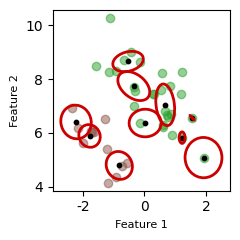

Figure saved as Images/synthetic_local_model_1.svg in svg format.
Figure saved as Images/synthetic_local_model_1.pdf in pdf format.


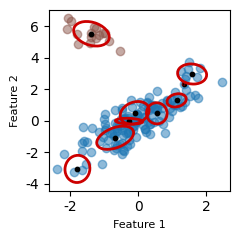

Figure saved as Images/synthetic_local_model_2.svg in svg format.
Figure saved as Images/synthetic_local_model_2.pdf in pdf format.


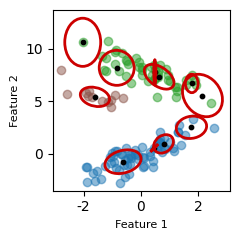

Figure saved as Images/synthetic_local_model_3.svg in svg format.
Figure saved as Images/synthetic_local_model_3.pdf in pdf format.


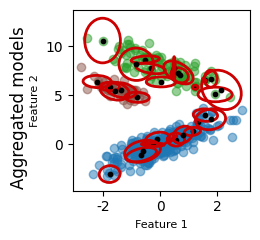

Figure saved as Images/synthetic_federated_pre_merge.svg in svg format.
Figure saved as Images/synthetic_federated_pre_merge.pdf in pdf format.
Number of clusters after merging = 9
Evolving has been disabled.


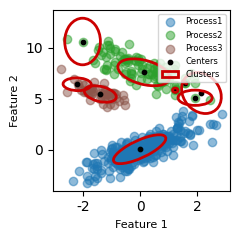

Figure saved as Images/synthetic_federated.svg in svg format.
Figure saved as Images/synthetic_federated.pdf in pdf format.

Experiment with 5 clients and 20.0% data per client
*** Start of fold 0 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 11
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 8
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 14
Training model for client 4
Evolving has been enabled.
Number of clusters with multiple samples for Client 4 = 13
Training model for client 5
Evolving has been enabled.
Number of clusters with multiple samples for Client 5 = 10
Number of clusters after merging = 14
Evolving has been disabled.
*** Start of fold 1 for this configuration. ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samp

In [5]:
# Non IID experiment
# Define the specific configurations of interest
specific_configurations = [
    (3, 0.33), (5, 0.20), (10, 0.10),  # 10% data for 3, 5, and 10 clients
]

experiment_non_iid_results = []

# Loop over the different configurations
for num_clients in num_clients_options:
    for data_percentage in data_percentage_options:
        # Check if the current configuration is one of the specific configurations of interest
        if (num_clients, data_percentage) in specific_configurations:
            print(f"\nExperiment with {num_clients} clients and {data_percentage*100}% data per client")
            
            kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

            # Initialize arrays to track samples per class for each client in each fold
            samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

            # Main loop for k-fold cross-validation
            #all_client_metrics = [[] for _ in range(num_clients)]
            all_client_clusters = [[] for _ in range(num_clients)]
            all_agregated_clusters = []
            all_federated_metrics = []
            all_federated_clusters = []

            # K-Fold Cross-Validation
            for i_fold, (train_index, test_index) in enumerate(kf.split(data)):
                print(f"*** Start of fold {i_fold} for this configuration. ***")

                # Split the data based on the current configuration
                train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(
                    X, y, train_index, test_index, num_clients)
                
                #Create the models
                local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
                federated_model = eGAUSSp(**federated_model_params)
                #federated_model.toggle_debugging(True)
                
                #Train the models
                for client_idx, client_model in enumerate(local_models):
                    #client_model.toggle_debugging(True)

                    # Count the number of samples per class for this client in this fold
                    for class_idx in range(client_model.num_classes):
                        class_samples = torch.sum(train_data[client_idx][1] == class_idx)
                        samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

                    #unsupervised clustering
                    print(f"Training model for client {client_idx + 1}")
                    train_unsupervised(client_model, train_data[client_idx]) 

                    #Test the local models

                    #Save the number of clusters
                    num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
                    print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
                    all_client_clusters[client_idx].append(num_client_clusters)

                #Aggregate local models
                for client_idx, client_model in enumerate(local_models):
                    federated_model.federal_agent.merge_model_privately(client_model, 1)
                    num_agregated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                    all_agregated_clusters.append(num_agregated_clusters)

                    #Plot local models
                    
                    if num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                            
                        #Plot the local models
                        fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="", format="%d")  #f"Local model {client_idx+1}"
                        save_figure(fig, f"Images/synthetic_local_model_{client_idx+1}.svg", "svg")
                        save_figure(fig, f"Images/synthetic_local_model_{client_idx+1}.pdf","pdf")
                    

                #Plot the Aggregated model
                if num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                    fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models", format="%.0f")   
                    save_figure(fig, "Images/synthetic_federated_pre_merge.svg","svg")
                    save_figure(fig, "Images/synthetic_federated_pre_merge.pdf","pdf")
                

                #Merge the federated model clusters
                #print(f"\nNumber of clusters after transfer = {federated_model.c}")
                federated_model.federal_agent.federated_merging()
                num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                print(f"Number of clusters after merging = {federated_model.c}")
                all_federated_clusters.append(num_federated_clusters)
                
                #Test the federated model
                #calculate_unsupervised_metrics()
                _,_, cluster_assignment = test_model(federated_model, test_data)

                federated_metrics = calculate_unsupervised_metrics(cluster_assignment, test_data)
                #num_params = federated_model.c*(federated_model.feature_dim**2 + federated_model.feature_dim +1)
                #bic = compute_bic(cluster_assignment.detach().numpy(), num_params)
                all_federated_metrics.append(federated_metrics)
                #all_federated_bic.append(bic)

                if num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                    fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="", legend = True, format="%d", data_name = "Process")   
                    save_figure(fig, "Images/synthetic_federated.svg","svg")
                    save_figure(fig, "Images/synthetic_federated.pdf","pdf")

            # After completing the folds, store the results for this configuration
            config_result = {
                "num_clients": num_clients,
                "data_percentage": data_percentage,
                "client_clusters": all_client_clusters,
                "aggregated_clusters": all_agregated_clusters,
                "federated_metrics": all_federated_metrics,
                "federated_clusters": all_federated_clusters,
                "num_of_samples": samples_per_class_per_client
            }
            experiment_non_iid_results.append(config_result)

In [6]:
#Aditional plots of the data
'''
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/synthetic_data_distribution.svg","svg")
save_figure(fig, "Images/synthetic_data_distribution.pdf","pdf")
'''

'\ndisplay_dataset_split(train_data, test_data)\nfig = plot_dataset_split(train_data, test_data)\nsave_figure(fig, "Images/synthetic_data_distribution.svg","svg")\nsave_figure(fig, "Images/synthetic_data_distribution.pdf","pdf")\n'

In [7]:
# After all configurations, process each configuration separately
for config in experiment_results:
    num_clients = config['num_clients']
    data_percentage = config['data_percentage']
    print(f"\nResults for {num_clients} clients with {data_percentage*100}% data:")

    # Calculate the average samples per class for each client
    average_samples_per_class_per_client = np.mean(np.sum(np.mean(config['num_of_samples'], axis=2), axis=1))
    print("Average samples per class for each client:")
    print(average_samples_per_class_per_client)

    # Calculate and print metrics for the current configuration
    avg_std_fed_metrics = calculate_metrics_statistics(config['federated_metrics'])
    print("Federated Model - Metrics (mean ± std):")
    for metric, value in avg_std_fed_metrics.items():
        print(f"{metric}: {value}")

    # Calculate and print cluster stats
    client_clusters = [cluster for client in config['client_clusters'] for cluster in client]
    avg_client_clusters, std_client_clusters = calculate_cluster_stats(client_clusters)
    print(f"Overall - Avg Clusters (mean ± std): {avg_client_clusters:.2f} ± {std_client_clusters:.2f}")

    avg_agg_clusters, std_agg_clusters = calculate_cluster_stats(config['aggregated_clusters'])
    print(f"Aggregated Model - Avg Clusters (mean ± std): {avg_agg_clusters:.2f} ± {std_agg_clusters:.2f}")

    avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(config['federated_clusters'])
    print(f"Federated Model - Avg Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


Results for 1 clients with 100% data:
Average samples per class for each client:
320.0
Federated Model - Metrics (mean ± std):
silhouette_score: 0.53{±}0.12
normalized_mutual_info_score: 0.74{±}0.06
v_measure_score: 0.74{±}0.06
Overall - Avg Clusters (mean ± std): 4.80 ± 0.84
Aggregated Model - Avg Clusters (mean ± std): 4.80 ± 0.84
Federated Model - Avg Clusters (mean ± std): 4.00 ± 0.71

Results for 3 clients with 10.0% data:
Average samples per class for each client:
32.0
Federated Model - Metrics (mean ± std):
silhouette_score: 0.16{±}0.10
normalized_mutual_info_score: 0.67{±}0.06
v_measure_score: 0.67{±}0.06
Overall - Avg Clusters (mean ± std): 9.87 ± 1.36
Aggregated Model - Avg Clusters (mean ± std): 19.60 ± 8.82
Federated Model - Avg Clusters (mean ± std): 12.60 ± 1.14

Results for 3 clients with 20.0% data:
Average samples per class for each client:
64.0
Federated Model - Metrics (mean ± std):
silhouette_score: 0.26{±}0.14
normalized_mutual_info_score: 0.68{±}0.08
v_measure_sc

In [8]:
# Define the LaTeX table header and footer
table_header = r'''\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Unsupervised Clustering for Different Client Data Distributions}
\begin{tabular}{lcccccc}
\toprule
\textbf{\#Clients/Data}&\textbf{\#Local$\downarrow$}&\textbf{\#Aggre.$\downarrow$}&\textbf{\#Fed.$\downarrow$}&\textbf{S$\uparrow$}&\textbf{ARI$\uparrow$}&\textbf{CH$\uparrow$}\\ 
\midrule
'''
def format_row(num_clients, data_percentage, results):
    # Extract federated metrics
    avg_std_fed_metrics = calculate_metrics_statistics(results['federated_metrics'])

    # Calculate cluster stats
    client_clusters = [cluster for client in results['client_clusters'] for cluster in client]
    avg_client_clusters, std_client_clusters = calculate_cluster_stats(client_clusters)
    avg_agg_clusters, std_agg_clusters = calculate_cluster_stats(results['aggregated_clusters'])
    avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(results['federated_clusters'])

    # Compute average number of samples
    samples = f"{int(np.mean(np.sum(np.mean(results['num_of_samples'], axis=2), axis=1))):d}"
    
    # Extract metrics
    silhouette_score = avg_std_fed_metrics["silhouette_score"]
    nmi_score = avg_std_fed_metrics["normalized_mutual_info_score"]
    v_measure_score = avg_std_fed_metrics['v_measure_score']

    # Format cluster data
    local_clusters = f"{avg_client_clusters:.1f}"+ r"{±}" +f"{std_client_clusters:.1f}"
    aggre_clusters = f"{avg_agg_clusters:.1f}"+ r"{±}" +f"{std_agg_clusters:.1f}"
    fed_clusters = f"{avg_fed_clusters:.1f}"+ r"{±}" +f"{std_fed_clusters:.1f}"

    # Format and return the row string
    return f"{num_clients}/{int(data_percentage * 100)}"+r"\%" +f"({samples})&{local_clusters}&{aggre_clusters}&{fed_clusters}&{silhouette_score}&{nmi_score}&{v_measure_score}\\\\"

# Generate the table rows for each part
def generate_table_rows(experiments, part_filter):
    table_rows = ""
    for config in experiments:
        if part_filter(config):
            num_clients = config['num_clients']
            data_percentage = config['data_percentage']
            table_rows += format_row(num_clients, data_percentage, config) + "\n"
    return table_rows

# Define filters for each part of the table
def is_part0(config):
    # Part 1: Experiments with data_percentage of 0.1
    return config['data_percentage'] == 1

# Define filters for each part of the table
def is_part1(config):
    # Part 1: Experiments with data_percentage of 0.1
    return config['data_percentage'] == 0.1

def is_part2(config):
    # Part 2: Experiments with 3 clients
    return config['num_clients'] == 3

def is_part3(config):
    # Hypothetical condition: non-iid experiment
    return config in experiment_non_iid_results

# Create rows for each part
part0_rows = generate_table_rows(experiment_results, is_part0)
part1_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 1: Influence of Number of Clients with Equal Data Size}} \\
''' + generate_table_rows(experiment_results, is_part1)
part2_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 2:  Influence of Data Percentage per Client}} \\
''' + generate_table_rows(experiment_results, is_part2)
part3_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 3: Influence of Number of Clients with Non-IID Data}} \\
''' + generate_table_rows(experiment_non_iid_results, is_part3)

# Define the table footer
table_footer = r'''\bottomrule
\multicolumn{7}{p{0.95\linewidth}}{\textbf{Note:} Clustering evaluation metrics used in the table: Silhouette score (S), Adjusted Rand Index (ARI), Calinski-Harabasz index (CH).}
\end{tabular}
\label{tab:unsupervised_metrics}
\end{table}'''

# Combine everything into the final LaTeX table
latex_table = table_header + part0_rows + part1_rows + part2_rows + part3_rows + table_footer

# Output the LaTeX table
print(latex_table)

\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Unsupervised Clustering for Different Client Data Distributions}
\begin{tabular}{lcccccc}
\toprule
\textbf{\#Clients/Data}&\textbf{\#Local$\downarrow$}&\textbf{\#Aggre.$\downarrow$}&\textbf{\#Fed.$\downarrow$}&\textbf{S$\uparrow$}&\textbf{ARI$\uparrow$}&\textbf{CH$\uparrow$}\\ 
\midrule
1/100\%(320)&4.8{±}0.8&4.8{±}0.8&4.0{±}0.7&0.53{±}0.12&0.74{±}0.06&0.74{±}0.06\\
\midrule
\multicolumn{7}{l}{\textbf{Experiment 1: Influence of Number of Clients with Equal Data Size}} \\
3/10\%(32)&9.9{±}1.4&19.6{±}8.8&12.6{±}1.1&0.16{±}0.10&0.67{±}0.06&0.67{±}0.06\\
5/10\%(32)&9.3{±}1.4&28.2{±}13.5&13.6{±}0.5&0.18{±}0.07&0.60{±}0.07&0.60{±}0.07\\
10/10\%(32)&9.2{±}1.8&50.9{±}26.8&12.8{±}1.6&-0.02{±}0.10&0.70{±}0.07&0.70{±}0.07\\
\midrule
\multicolumn{7}{l}{\textbf{Experiment 2:  Influence of Data Percentage per Client}} \\
3/10\%(32)&9.9{±}1.4&19.6{±}8.8&12.6{±}1.1&0.16{±}0.10&0.67{±}0.06&0.67{±}0.06\\
3/20\%(64)&10.9{±}1.7&

In [9]:
'''
#Calculate evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)
                          
print("\nFederated Model - Metrics (mean ± std):")
for metric, value in avg_std_federated_metrics.items():
    print(f"{metric}: {value}")

# Compute and print cluster stats for each client and federated model
#for client_idx, client_clusters in enumerate(all_client_clusters):
#    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
#    print(f"Client {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Flatten the list of lists to get all cluster counts across all clients and folds
all_clusters = [cluster_count for client_clusters in all_client_clusters for cluster_count in client_clusters]

# Calculate the overall average and standard deviation
avg_clusters, std_clusters = calculate_cluster_stats(all_clusters)
print(f"Overall - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and print cluster stats for the agregared models before merging into the  federated model
avg_agr_clusters, std_agr_clusters = calculate_cluster_stats(all_agregated_clusters)
print(f"Agregated Model - Average Number of Clusters (mean ± std): {avg_agr_clusters:.2f} ± {std_agr_clusters:.2f}")

# Compute and print cluster stats for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"Federated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")
'''

'\n#Calculate evaluation metrics for the federated model\navg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)\n                          \nprint("\nFederated Model - Metrics (mean ± std):")\nfor metric, value in avg_std_federated_metrics.items():\n    print(f"{metric}: {value}")\n\n# Compute and print cluster stats for each client and federated model\n#for client_idx, client_clusters in enumerate(all_client_clusters):\n#    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)\n#    print(f"Client {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")\n\n# Flatten the list of lists to get all cluster counts across all clients and folds\nall_clusters = [cluster_count for client_clusters in all_client_clusters for cluster_count in client_clusters]\n\n# Calculate the overall average and standard deviation\navg_clusters, std_clusters = calculate_cluster_stats(all_clusters)\nprint(f"Overall - Average 